In [14]:
from dataclasses import replace 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

df=pd.read_csv("AAPL.csv")
df["date"]=pd.to_datetime(df["date"])
df["close"]=df["close"].astype(float)

# Prediction on Apple Stocks

We are observing and predicting the prices at the closing of the apple stocks.

In [15]:

df.isna().sum()

Unnamed: 0     0
symbol         0
date           0
close          0
high           0
low            0
open           0
volume         0
adjClose       0
adjHigh        0
adjLow         0
adjOpen        0
adjVolume      0
divCash        0
splitFactor    0
dtype: int64

When we plot the graph it seems to have a trend. But we can"t be sure by the seasonality. The data are not stationary so we can't use the ARIMA model. 

                           Unnamed: 0       close        high         low  \
date                                                                        
2015-05-31 00:00:00+00:00         1.0  131.368333  131.886667  130.350000   
2015-06-30 00:00:00+00:00        13.5  127.806364  128.761136  127.240645   
2015-07-31 00:00:00+00:00        35.5  125.335455  126.203518  124.340000   
2015-08-31 00:00:00+00:00        57.0  113.394762  115.500000  111.290476   
2015-09-30 00:00:00+00:00        78.0  112.797619  114.207262  111.523624   
2015-10-31 00:00:00+00:00        99.5  113.360000  114.132336  111.875227   
2015-11-30 00:00:00+00:00       120.5  118.162250  119.272000  117.256550   
2015-12-31 00:00:00+00:00       141.5  111.726818  113.021364  110.741941   
2016-01-31 00:00:00+00:00       162.0   98.428947   99.949295   96.928416   
2016-02-29 00:00:00+00:00       181.5   95.746500   96.727680   94.711550   
2016-03-31 00:00:00+00:00       202.5  104.267273  104.897268  103.231368   

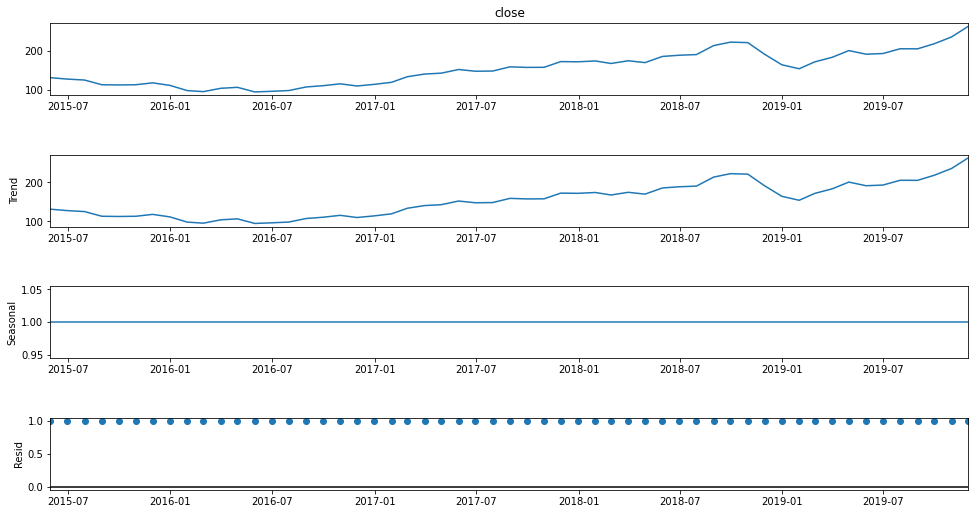

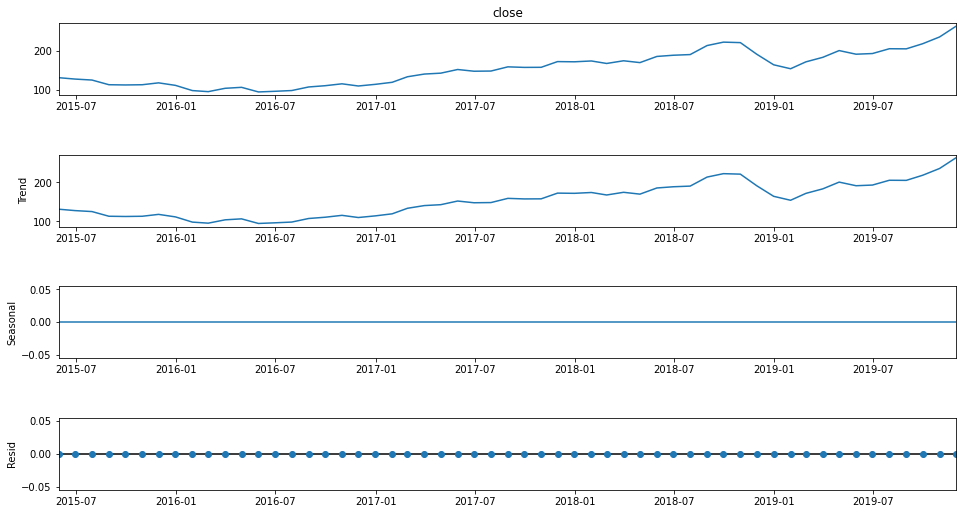

In [16]:
from statsmodels.tsa.seasonal import seasonal_decompose
df1=df.resample("M",on='date').mean()
df_train=df1[0:55]
df_test=df1[55:61]
print(df_train)

decompose_multiplicative= seasonal_decompose(df_train["close"],model='multiplicative', period=1)
fig1=decompose_multiplicative.plot()
fig1.set_size_inches(15,8)


decompose_additive = seasonal_decompose(df_train["close"], model='additive', period=1)
fig2=decompose_additive.plot()
fig2.set_size_inches(15,8)


For the two types of decomposition, there isn't seonality. The trend is exactly the same that the price, this means we need to check if the trend component is time-dependent (using rolling stat, for example). And there is also residual component. \
\
Rolling statistics: Plot the moving average and moving standard deviation.\
The time series is stationary if it remains constant over time (by eye, look to see if the lines are straight and parallel to the x-axis)

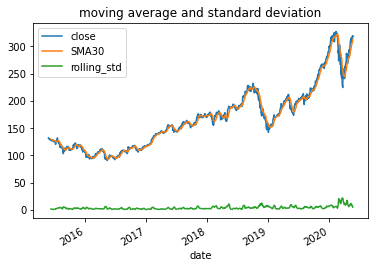

In [17]:
df['SMA30']=df['close'].rolling(window=12).mean()
ax=plt.gca()
df['rolling_std'] = df['close'].rolling(window = 12).std()
df.plot(kind='line',x='date',y='close', ax=ax)
df.plot(kind='line',x='date',y='SMA30', ax=ax)
df.plot(kind='line',x='date',y='rolling_std', ax=ax)
plt.title('moving average and standard deviation')
plt.show()





As you can see, the moving average is increases with time. We can therefore conclude that the time series is not stationary (there is time-depencies).

Now, we're going to detrend the series to make it stationary using the same moving average that above avoiding over differencing.

### Detrend by moving average

0     -2.834596
1     -8.784098
2     -4.378326
3      0.175873
4      3.388960
5     -2.689538
6    -11.010391
7     -6.220922
8      4.786366
9      4.488108
10    -7.018932
11    -2.823088
12     1.838655
13     6.717221
14     5.164189
15     4.297308
16    -2.085238
17     0.936667
18     4.883333
19    11.174060
20     9.317235
21     3.813970
22     6.983595
23     0.182719
24    -1.153364
25     7.303915
26     2.632065
27    -0.331753
28     9.795536
29     4.519846
30     1.237595
31    -3.539614
32     2.449398
33    -0.822189
34     8.914387
35     7.290584
36     2.154870
37    15.919772
38    13.496618
39     2.090511
40   -20.149303
41   -27.849578
42   -15.723216
43     8.341094
44    13.564511
45    15.336892
46    -0.420909
47    -1.950609
48     8.730030
49     3.910030
50     8.605136
51    15.873522
52    23.919909
Name: close, dtype: float64


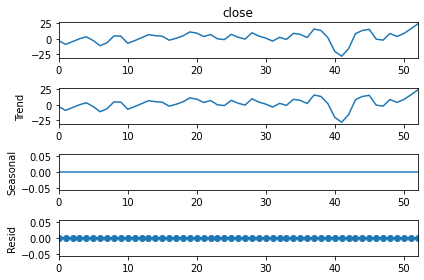

In [18]:
df_train_detrend = (df_train['close'] - df_train['close'].rolling(3).mean())[2:].reset_index(drop=True)
print(df_train_detrend)
SD_additive = seasonal_decompose(df_train_detrend, model='additive', period=1)

plt.show()
SD_additive.plot()
plt.show()

Here, we are decomposing our time serie. We can clearly observe an increasing trend. Also, we can see that there is a seasonality on the year.

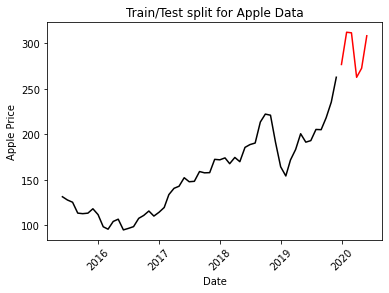

In [19]:
plt.plot(df_train["close"], color = "black")
plt.plot(df_test["close"], color = "red")
plt.ylabel('Apple Price')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Train/Test split for Apple Data")
plt.show()

We are spliting our dataset to see if our training is right.

For forecasting, we need make sure that the residual component is stationary, it hasn't time dependency. Graphically, they are some trends through time, so it seems the TS is not stationary, but we decided to perform a test.

### Perform augmented Dickey-Fuller stationary test

H0: the TS is non-stationary. In other words, it has some time-dependent structure and does not have constant variance over time. \
H1: the TS is stationary 

In [20]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df_train_detrend, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'n_lags: {result[1]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -5.0118587504879475
n_lags: 2.102455468834644e-05
p-value: 2.102455468834644e-05
Critial Values:
   1%, -3.5656240522121956
Critial Values:
   5%, -2.920142229157715
Critial Values:
   10%, -2.598014675124952


p-value = 0.005< 0.05 \
We succeed to reject the hypothesis H0 \
==> the time-series is stationary and thus there is no more time-dependancy to remove

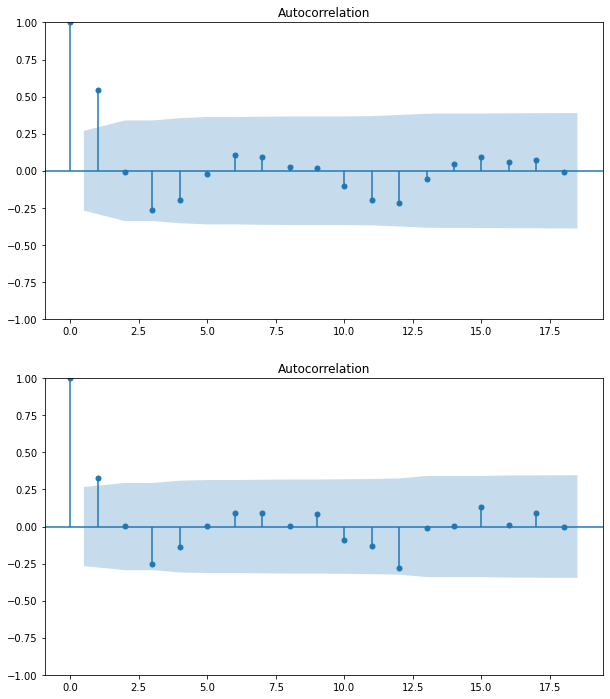

<Figure size 432x288 with 0 Axes>

In [21]:
from statsmodels.graphics.tsaplots import plot_acf
##plot_acf(df_train["close"])
fig, ax = plt.subplots(2, 1, figsize=(10, 12))
plot_acf(df_train_detrend,ax=ax[0])
f=plt.figure()
##ax1=f.add_subplot()
plot_acf(df_train['close'].diff().dropna(),ax=ax[1])
plt.show()



 There is not seasonality. There is many point who have autocorrelation. 
 The autocorrelation chart shows us that until 1 lags the correlation is significant, so we're going to give the value 1 to the q variable. 
 And the value of p is going to be 0 because all the the autocorrelation is no significant 


### Forecasting using the model ARIMA

The model ARIMA is using for forecast time-series that have only a trend and a residual component. In the model, we need three hyperparameters: 

p is the order of the AR term 

q is the order of the MA term 

d is the number of differencing required to make the time series stationary

We already show that just one differencing makes the TS stationary. So we always need to find p and q. Plot the autocorrelation is the solution.

We can see that there is a white noise that is not significant.

So we can define the order of our ARIMA model 

In [22]:
from statsmodels.tsa.arima.model import ARIMA
out_put=df_train["close"]

In [23]:
import pmdarima as pm

model = pm.auto_arima(df_train['close'], start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=409.166, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=412.264, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=407.433, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=407.895, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=413.025, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=408.779, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=409.348, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=406.917, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=408.505, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=408.727, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=407.830, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=409.801, Time=0.05 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.389 seconds
                               SARIMAX Results                                
Dep. Variable:       

In [24]:

ARIMAmodel = ARIMA(out_put, order = (0, 2, 1))
ARIMAmodel = ARIMAmodel.fit()

print(ARIMAmodel.summary())
y_pred = ARIMAmodel.get_forecast(len(df_test.index))
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = ARIMAmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = df_test.index
y_pred_out = y_pred_df["Predictions"] 

import numpy as np
from sklearn.metrics import mean_squared_error

arma_rmse = np.sqrt(mean_squared_error(df_test["close"].values, y_pred_df["Predictions"]))
print("RMSE: ",arma_rmse)


                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                   55
Model:                 ARIMA(0, 2, 1)   Log Likelihood                -202.207
Date:                Tue, 22 Nov 2022   AIC                            408.414
Time:                        19:08:13   BIC                            412.355
Sample:                    05-31-2015   HQIC                           409.930
                         - 11-30-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8584      0.073    -11.742      0.000      -1.002      -0.715
sigma2       117.6044     18.290      6.430      0.000      81.756     153.453
Ljung-Box (L1) (Q):                   4.05   Jarque-

We are ploting the trend to compare it to the reality

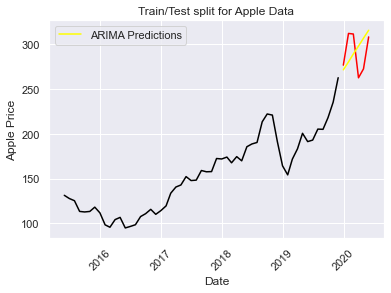

In [25]:
import seaborn as sns
sns.set()
plt.plot(df_train["close"], color = "black")
plt.plot(df_test["close"], color = "red")
plt.ylabel('Apple Price')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Train/Test split for Apple Data")
plt.plot(y_pred_out, color='Yellow', label = 'ARIMA Predictions')
plt.legend()
plt.show()

We can clearly see that the prediction is right even if you don't have the residuals.

In [26]:
y_pred_out

date
2019-12-31 00:00:00+00:00    271.343258
2020-01-31 00:00:00+00:00    280.166016
2020-02-29 00:00:00+00:00    288.988773
2020-03-31 00:00:00+00:00    297.811531
2020-04-30 00:00:00+00:00    306.634289
2020-05-31 00:00:00+00:00    315.457047
Freq: M, Name: Predictions, dtype: float64

Here we are going to do the prediction for this period. We are using the ARIMA model to do it.

In [27]:
import pmdarima as pm

model = pm.auto_arima(df_train['close'], start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=409.166, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=412.264, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=407.433, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=407.895, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=413.025, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=408.779, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=409.348, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=406.917, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=408.505, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=408.727, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=407.830, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=409.801, Time=0.06 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.371 seconds
                               SARIMAX Results                                
Dep. Variable:       

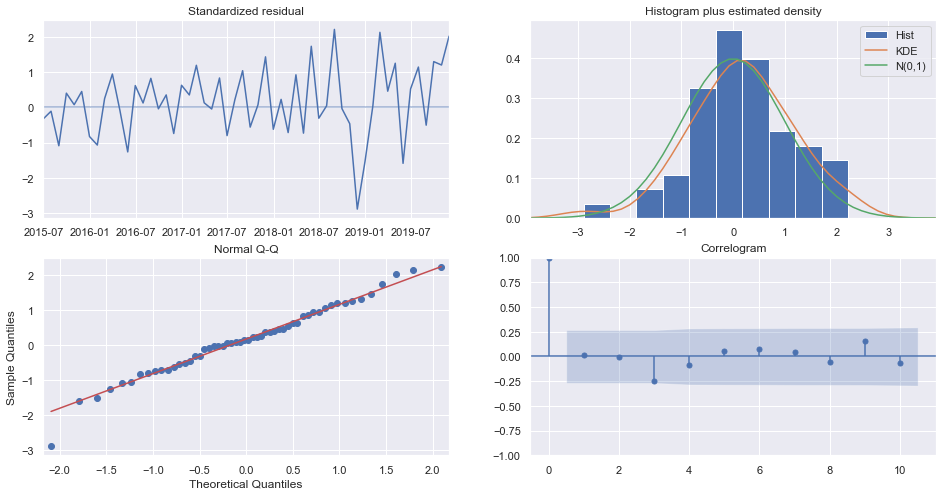

In [28]:
model.plot_diagnostics(figsize=(16,8))
plt.show()

The residual errors seem to fluctuate around a mean of zero and have a uniform variance between (-1.5, 2.5).

The density plot don't really suggest normal distribution with mean zero

The most part of the blue dots are over the red line, so it seems that the distribution in very low skewed

he Correlogram, aka, ACF plot shows the residual errors are autocorrelated.

To conclude, we can say that this time serie will continue to increase and so the Apple stock will be increasing. It will be a good thing to invest in it.

In [98]:

TRAIN_SPLIT = int(df1.shape[0] * 0.8)
train, test = df1.iloc[:TRAIN_SPLIT], df1.iloc[TRAIN_SPLIT:]
predictions = []
for i in range(len(test)):

    train, test = df1.iloc[:TRAIN_SPLIT+i], df1.iloc[TRAIN_SPLIT+i:]
    
    model = ARIMA(train['close'], order=(2, 1, 1))
    model_fit = model.fit()
    pred = model_fit.predict(TRAIN_SPLIT+i, len(df1)-1)
    predictions.append(pred[0])
   

train, test = df1.iloc[:TRAIN_SPLIT], df1.iloc[TRAIN_SPLIT:]


C:\Users\taina\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\taina\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\taina\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting aut

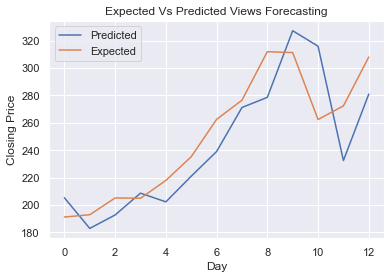

In [99]:
##labels={'Predicted','Expected'}
plt.plot(predictions,label='predicted')
plt.plot(test['close'].reset_index(drop=True),label='Expected')
plt.title('Expected Vs Predicted Views Forecasting')
plt.xlabel('Day')
plt.ylabel('Closing Price')
plt.legend(labels)
plt.show()